In [1]:
from src.utils.PathManager import Paths as Path 
from src.utils.Visualisation import plot_ROC_simple
from src.utils.BayesianLabel import BayesianLabeler as Labeller 
from src.utils.FeatureExtractor import *
import pandas as pd 
import numpy as np 
from datetime import timedelta
import matplotlib.pyplot as plt 
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

In [9]:
well_code = "WKT3"

In [10]:
model = FeatureExtractor(well_code)

## Get dawn gradient label 

In [ ]:
gradient_label_df = model.get_dawn_VOLTAGE_drop_failure_label()

In [ ]:
model.evaluate_labeller(gradient_label_df)

## Get dawn data-outage label

In [ ]:
outage_label_df = model.get_data_outage_failure_label()

In [ ]:
model.evaluate_labeller(outage_label_df)

# Get charging fault label 

In [4]:
charging_fault_label = model.get_charging_fault_label()

In [5]:
len(charging_fault_label[charging_fault_label==1])

3

In [6]:
charging_fault_label[charging_fault_label==1]

2020-10-25    1
2020-10-26    1
2020-10-27    1
dtype: int64

In [7]:
model.data['label_df']

,labels
2019-02-20,4
2019-02-22,4
2019-06-11,5
2020-10-27,6
2020-10-28,6
2021-05-08,8


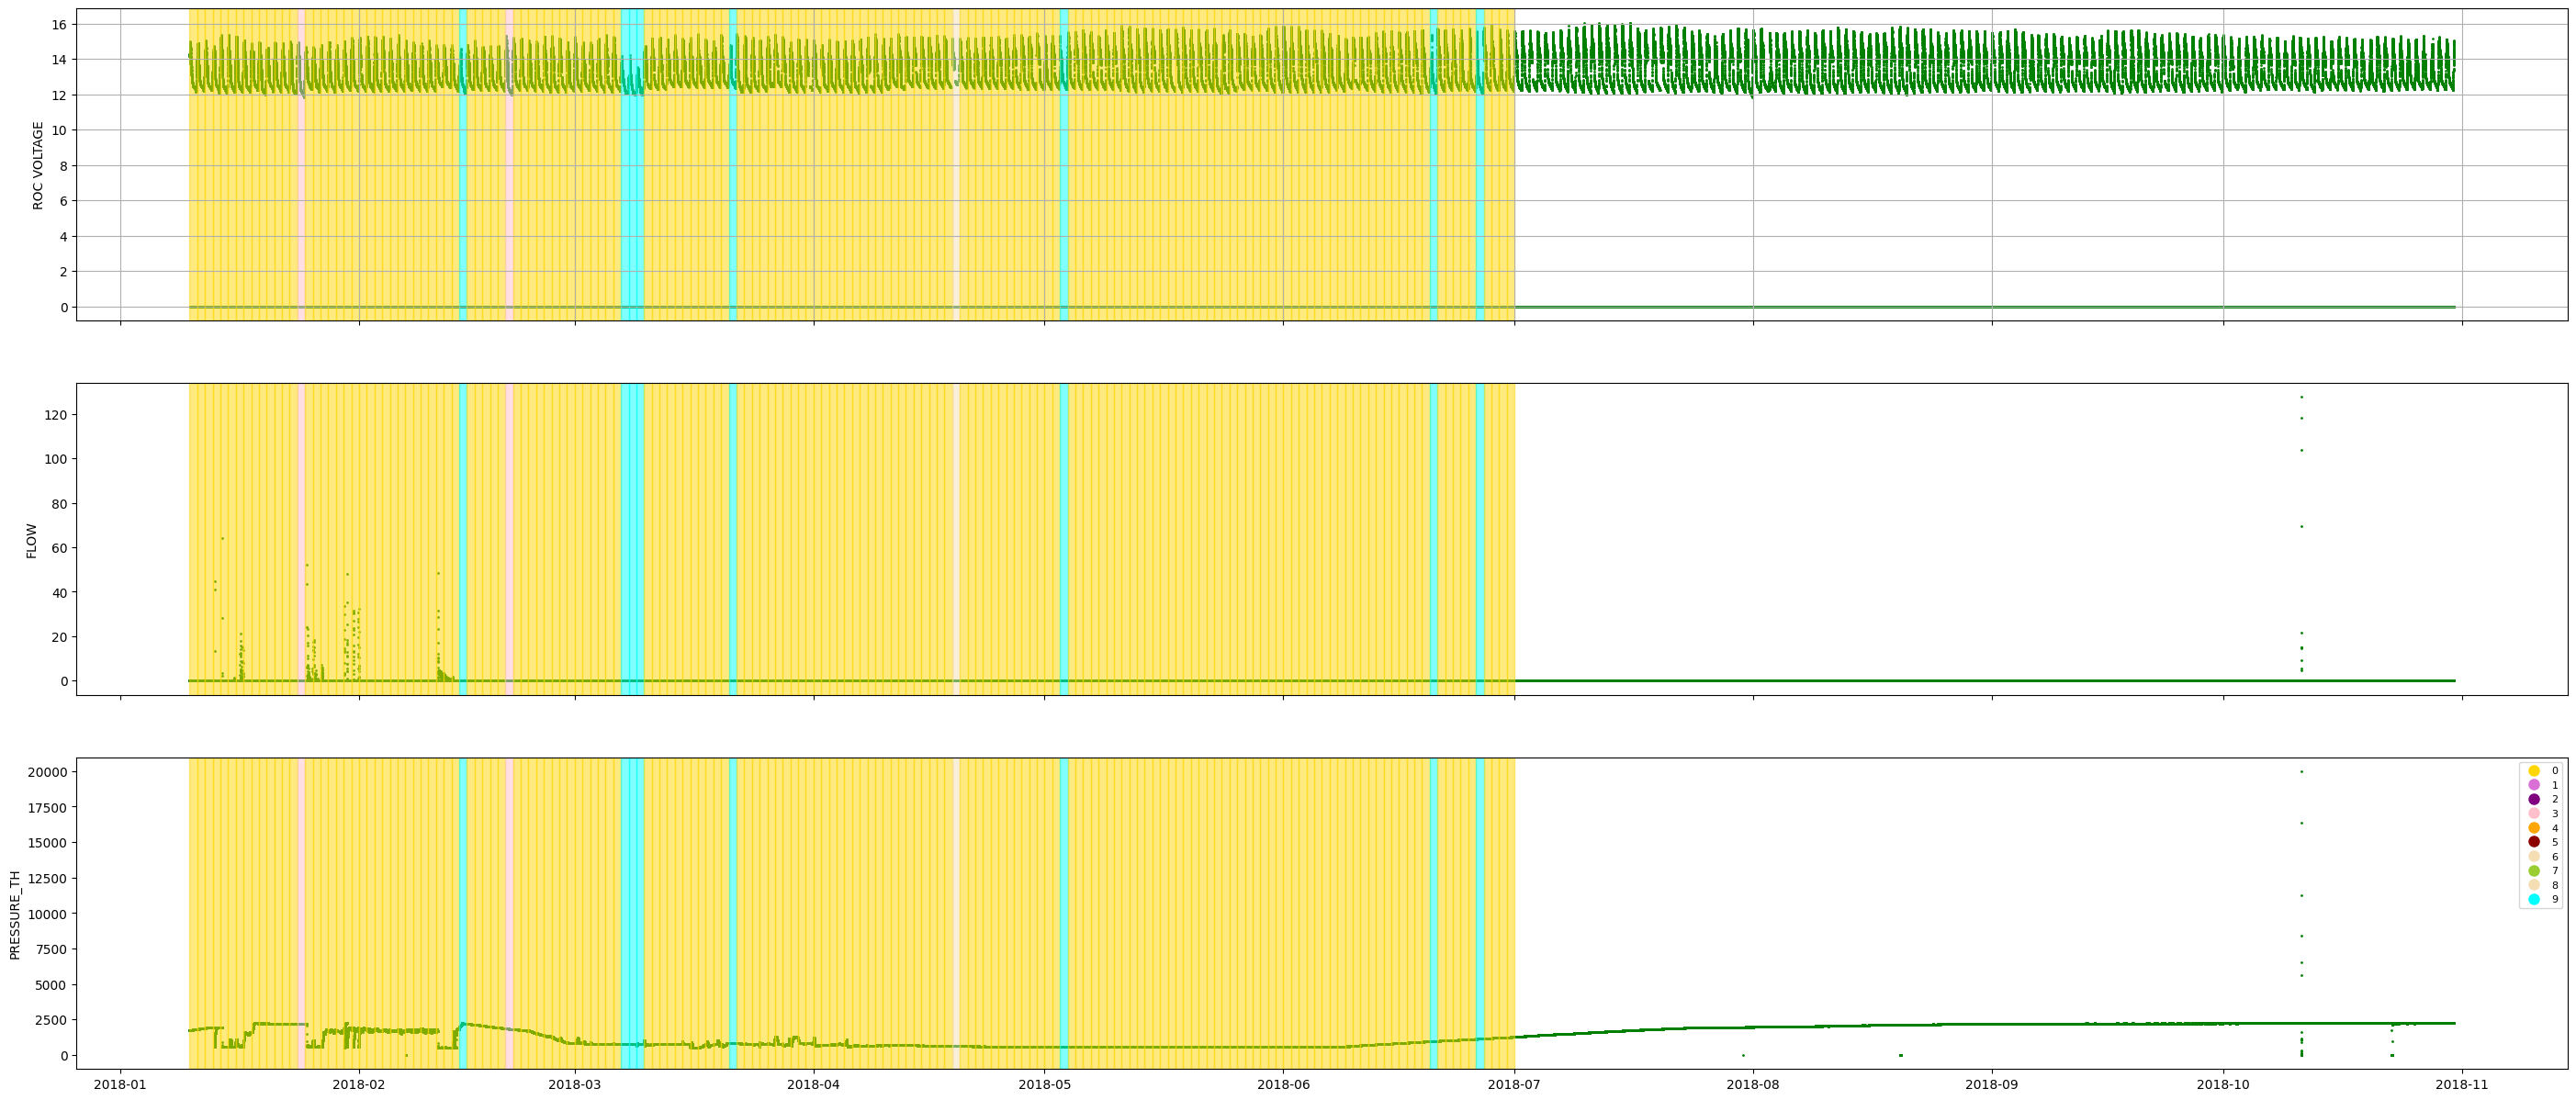

In [17]:

plot_ROC_simple(model.data['raw_df'],model.data['label_df'],"2018-01-10","2018-10-30")
plt.show()

In [14]:
gt_df = model.data['label_df']
gt_df = gt_df[gt_df.labels==9]

In [15]:
gt_df

,labels
2018-02-14,9
2018-03-07,9
2018-03-08,9
2018-03-09,9
2018-03-21,9
2018-05-03,9
2018-06-20,9
2018-06-26,9
